In [7]:
# ============================================================================
# CELL 1: Set Up Directories
# ============================================================================

import os

# Define local paths
BASE_DIR = os.path.abspath("Pipe Counter")
TRAIN_PATH = os.path.join(BASE_DIR, 'train')
VALID_PATH = os.path.join(BASE_DIR, 'valid')
TEST_PATH = os.path.join(BASE_DIR, 'test')

# Verify paths exist
for path in [BASE_DIR, TRAIN_PATH, VALID_PATH, TEST_PATH]:
    if os.path.exists(path):
        print(f"✓ Found: {path}")
    else:
        print(f"✗ Missing: {path}")

✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter
✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/train
✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/valid
✓ Found: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/test


In [8]:
# ============================================================================
# CELL 2: Import Libraries and Set Device
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from collections import defaultdict
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cpu


In [9]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [10]:
# ============================================================================
# CELL 3: Dataset Class for COCO Format
# ============================================================================

class PipeDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        
        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create image id to annotations mapping
        self.image_info = {img['id']: img for img in self.coco_data['images']}
        
        # Group annotations by image_id
        self.annotations_by_image = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.annotations_by_image[ann['image_id']].append(ann)
        
        # Get list of image IDs that have annotations
        self.image_ids = list(self.annotations_by_image.keys())
        
        print(f"Dataset loaded: {len(self.image_ids)} images with annotations")
        
        # Calculate pipe count distribution
        pipe_counts = [len(self.annotations_by_image[img_id]) for img_id in self.image_ids]
        print(f"Pipe count stats - Min: {min(pipe_counts)}, Max: {max(pipe_counts)}, Mean: {np.mean(pipe_counts):.2f}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Get image ID
        image_id = self.image_ids[idx]
        
        # Get image info
        image_info = self.image_info[image_id]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # Get annotations for this image
        annotations = self.annotations_by_image[image_id]
        
        # Extract bounding boxes and labels
        boxes = []
        labels = []
        areas = []
        
        for ann in annotations:
            bbox = ann['bbox']  # COCO format: [x, y, width, height]
            
            # Convert to [x1, y1, x2, y2] format
            x1, y1, w, h = bbox
            x2 = x1 + w
            y2 = y1 + h
            
            # Ensure valid bounding box
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(image.width, x2)
            y2 = min(image.height, y2)
            
            if x2 > x1 and y2 > y1:  # Valid box
                boxes.append([x1, y1, x2, y2])
                labels.append(1)  # Pipe class (1-indexed for torchvision)
                areas.append(w * h)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': areas,
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }
        
        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
        
        return image, target


In [11]:
# ============================================================================
# CELL 4: Data Transforms and Augmentation
# ============================================================================

def get_transform(train=True):
    # ImageNet normalization (used by Faster R-CNN pretrained backbones)
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    if train:
        return transforms.Compose([
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.ToTensor(),
            normalize
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])

def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
# ============================================================================
# CELL 5: Create Datasets and DataLoaders
# ============================================================================

# Find annotation files
train_ann_file = None
valid_ann_file = None
test_ann_file = None

# Look for common annotation file names
for filename in ['annotations.json', 'instances_train.json', '_annotations.coco.json']:
    train_path = os.path.join(TRAIN_PATH, filename)
    if os.path.exists(train_path):
        train_ann_file = train_path
        break

for filename in ['annotations.json', 'instances_val.json', '_annotations.coco.json']:
    valid_path = os.path.join(VALID_PATH, filename)
    if os.path.exists(valid_path):
        valid_ann_file = valid_path
        break

for filename in ['annotations.json', 'instances_test.json', '_annotations.coco.json']:
    test_path = os.path.join(TEST_PATH, filename)
    if os.path.exists(test_path):
        test_ann_file = test_path
        break

print(f"Train annotations: {train_ann_file}")
print(f"Valid annotations: {valid_ann_file}")
print(f"Test annotations: {test_ann_file}")

# Create datasets
train_dataset = PipeDataset(
    root_dir=TRAIN_PATH,
    annotation_file=train_ann_file,
    transforms=get_transform(train=True)
)

valid_dataset = PipeDataset(
    root_dir=VALID_PATH,
    annotation_file=valid_ann_file,
    transforms=get_transform(train=False)
)

if test_ann_file:
    test_dataset = PipeDataset(
        root_dir=TEST_PATH,
        annotation_file=test_ann_file,
        transforms=get_transform(train=False)
)

# Create data loaders
BATCH_SIZE = 4  # Adjust based on your GPU memory
NUM_WORKERS = 0  # Set to 0 for Jupyter notebook compatibility

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

if test_ann_file:
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
)

print(f"Train batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")
if test_ann_file:
    print(f"Test batches: {len(test_loader)}")


Train annotations: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/train/_annotations.coco.json
Valid annotations: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/valid/_annotations.coco.json
Test annotations: /Users/kutadgu/Documents/MachineLearning/Pipe Counter/test/_annotations.coco.json
Dataset loaded: 1668 images with annotations
Pipe count stats - Min: 1, Max: 903, Mean: 63.26
Dataset loaded: 673 images with annotations
Pipe count stats - Min: 1, Max: 987, Mean: 75.55
Dataset loaded: 60 images with annotations
Pipe count stats - Min: 1, Max: 393, Mean: 55.60
Train batches: 417
Valid batches: 169
Test batches: 15
Dataset loaded: 1668 images with annotations
Pipe count stats - Min: 1, Max: 903, Mean: 63.26
Dataset loaded: 673 images with annotations
Pipe count stats - Min: 1, Max: 987, Mean: 75.55
Dataset loaded: 60 images with annotations
Pipe count stats - Min: 1, Max: 393, Mean: 55.60
Train batches: 417
Valid batches: 169
Test batches: 15


Sample training images:


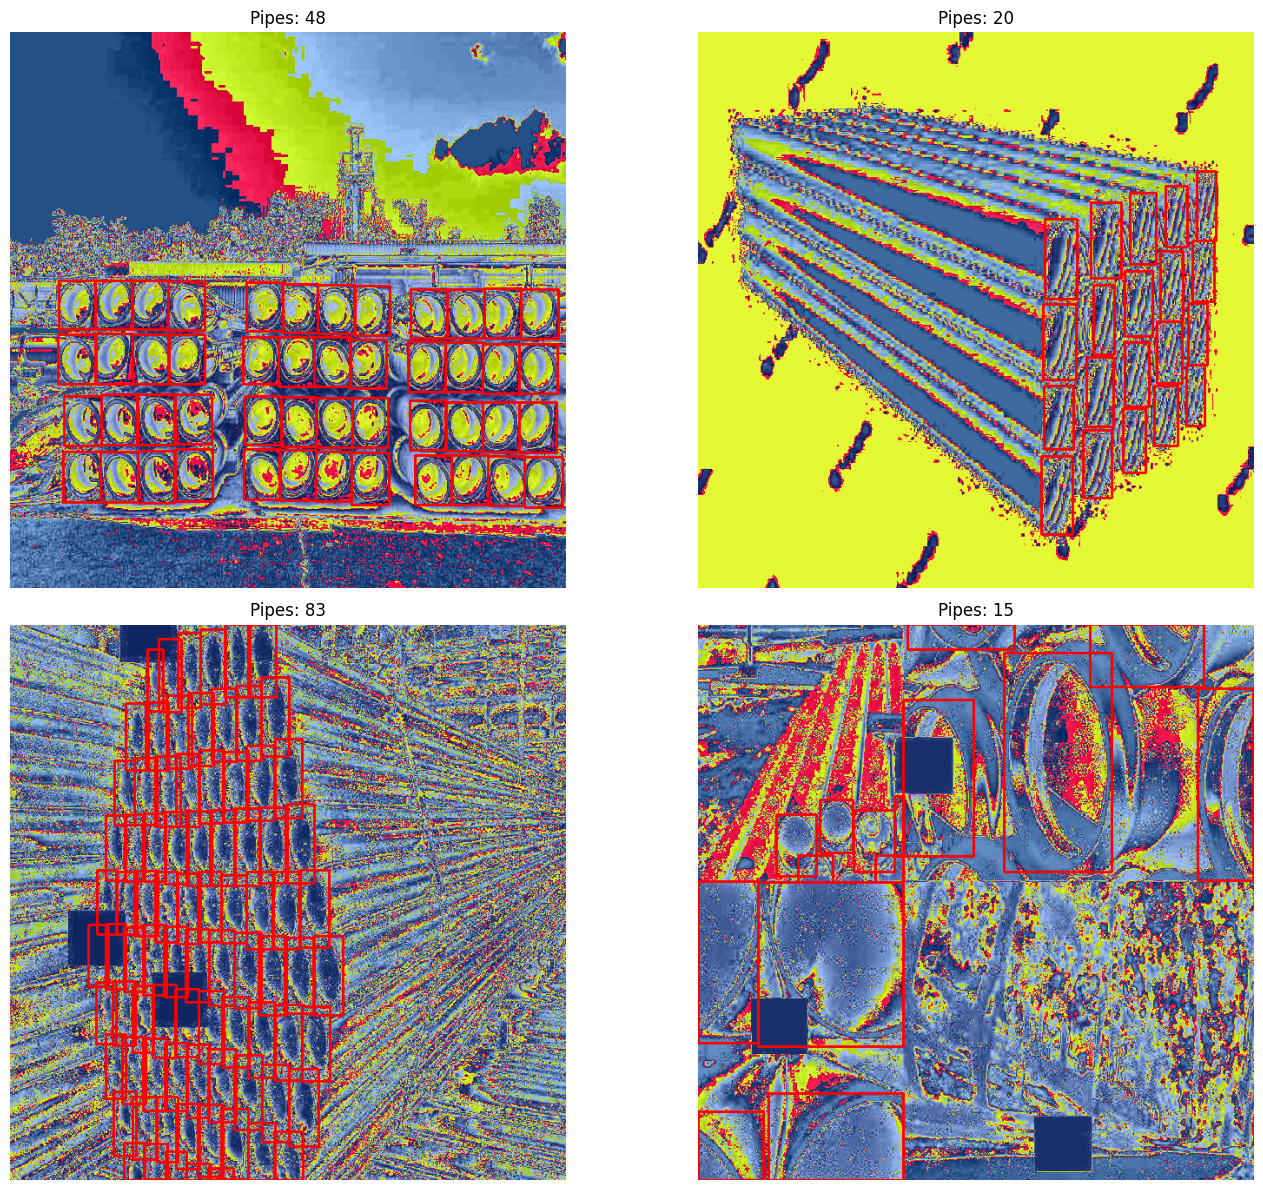

In [13]:
# ============================================================================
# CELL 6: Visualize Sample Data
# ============================================================================

def visualize_sample_data(dataset, num_samples=4):
    """Visualize sample images with bounding boxes"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(dataset))):
        image, target = dataset[i]
        
        # Convert tensor to PIL Image
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        
        # Convert to numpy array for visualization
        image_np = np.array(image)
        
        # Draw bounding boxes
        for box in target['boxes']:
            x1, y1, x2, y2 = box.cpu().numpy()
            cv2.rectangle(image_np, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        
        axes[i].imshow(image_np)
        axes[i].set_title(f'Pipes: {len(target["boxes"])}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training data
print("Sample training images:")
visualize_sample_data(train_dataset)


In [14]:
# ============================================================================
# CELL 7: Define Fast R-CNN Model
# ============================================================================

def create_model(num_classes=2):  # 1 class (pipe) + background
    """Create Fast R-CNN model with ResNet-50 backbone"""
    
    # Load pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Create model
model = create_model(num_classes=2)  # pipe + background
model.roi_heads.detections_per_img = 300 # manually set the instance per image limit higher
model.to(device)

print("Model created successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model created successfully!
Model parameters: 43,256,153
Trainable parameters: 43,030,809


In [15]:
# ============================================================================
# CELL 8: Training Configuration
# ============================================================================

# Training hyperparameters
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
MOMENTUM = 0.9
NUM_EPOCHS = 3
PATIENCE = 10  # Early stopping patience

# Optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

# For tracking training progress
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print("Training configuration:")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Device: {device}")


Training configuration:
Learning rate: 0.001
Batch size: 4
Epochs: 3
Device: cpu


In [16]:
# ============================================================================
# CELL 9: Training Functions
# ============================================================================

def train_one_epoch(model, optimizer, data_loader, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    
    for batch_idx, (images, targets) in enumerate(progress_bar):
        # Move to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += losses.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': losses.item(),
            'avg_loss': running_loss / (batch_idx + 1)
        })
    
    return running_loss / len(data_loader)

def validate_one_epoch(model, data_loader, device):
    """Validate for one epoch"""
    model.train()  # Keep in training mode for loss calculation
    running_loss = 0.0
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)
        
        for batch_idx, (images, targets) in enumerate(progress_bar):
            # Move to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Update running loss
            running_loss += losses.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': losses.item(),
                'avg_loss': running_loss / (batch_idx + 1)
            })
    
    return running_loss / len(data_loader)


In [11]:
# ============================================================================
# CELL 10: Training Loop
# ============================================================================
def count_pipes_from_targets(targets):
    """Helper to count pipes in targets (ground truth)"""
    return [len(t["boxes"]) for t in targets]

def count_pipes_from_outputs(outputs, conf_thresh=0.5):
    """Helper to count predicted pipes from model outputs with optional confidence threshold"""
    return [int((o["scores"] > conf_thresh).sum().item()) for o in outputs]

LOG_EVERY_N_BATCHES = 10  # Change this to control frequency of debug prints

print("Starting training...")
print("=" * 50)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 30)
    
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (images, targets) in enumerate(tqdm(train_loader)):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        batch_loss = losses.item()
        epoch_loss += batch_loss
        
        if (batch_idx + 1) % LOG_EVERY_N_BATCHES == 0:
            with torch.no_grad():
                model.eval()
                outputs = model(images)
                model.train()
                
                gt_counts = count_pipes_from_targets(targets)
                pred_counts = count_pipes_from_outputs(outputs)
                
                print(f"\nBatch {batch_idx + 1}/{len(train_loader)}")
                print(f"Batch Loss: {batch_loss:.4f}")
                for i, (gt, pred) in enumerate(zip(gt_counts, pred_counts)):
                    print(f"Image {i}: True pipes = {gt}, Predicted pipes = {pred}")
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    val_loss = validate_one_epoch(model, valid_loader, device)
    val_losses.append(val_loss)
    
    scheduler.step()
    
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Early stopping and checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'best_pipe_model.pth')  # Saved locally now
        print("✓ New best model saved!")
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break
    
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...

Epoch 1/3
------------------------------


  2%|▏         | 10/417 [01:56<1:24:59, 12.53s/it]


Batch 10/417
Batch Loss: 1.7527
Image 0: True pipes = 95, Predicted pipes = 0
Image 1: True pipes = 199, Predicted pipes = 0
Image 2: True pipes = 18, Predicted pipes = 0
Image 3: True pipes = 73, Predicted pipes = 0


  5%|▍         | 20/417 [03:51<1:22:26, 12.46s/it]


Batch 20/417
Batch Loss: 1.3010
Image 0: True pipes = 20, Predicted pipes = 23
Image 1: True pipes = 11, Predicted pipes = 6
Image 2: True pipes = 350, Predicted pipes = 111
Image 3: True pipes = 24, Predicted pipes = 27


  7%|▋         | 30/417 [05:45<1:22:00, 12.71s/it]


Batch 30/417
Batch Loss: 1.2309
Image 0: True pipes = 80, Predicted pipes = 77
Image 1: True pipes = 24, Predicted pipes = 41
Image 2: True pipes = 245, Predicted pipes = 105
Image 3: True pipes = 259, Predicted pipes = 166


 10%|▉         | 40/417 [07:41<1:20:02, 12.74s/it]


Batch 40/417
Batch Loss: 1.0571
Image 0: True pipes = 7, Predicted pipes = 16
Image 1: True pipes = 12, Predicted pipes = 15
Image 2: True pipes = 10, Predicted pipes = 29
Image 3: True pipes = 152, Predicted pipes = 86


 12%|█▏        | 50/417 [09:39<1:18:52, 12.90s/it]


Batch 50/417
Batch Loss: 1.3721
Image 0: True pipes = 72, Predicted pipes = 68
Image 1: True pipes = 206, Predicted pipes = 90
Image 2: True pipes = 45, Predicted pipes = 39
Image 3: True pipes = 29, Predicted pipes = 31


 14%|█▍        | 60/417 [11:36<1:16:15, 12.82s/it]


Batch 60/417
Batch Loss: 0.6802
Image 0: True pipes = 8, Predicted pipes = 9
Image 1: True pipes = 65, Predicted pipes = 64
Image 2: True pipes = 101, Predicted pipes = 88
Image 3: True pipes = 63, Predicted pipes = 69


 17%|█▋        | 70/417 [13:32<1:11:56, 12.44s/it]


Batch 70/417
Batch Loss: 0.6685
Image 0: True pipes = 8, Predicted pipes = 8
Image 1: True pipes = 41, Predicted pipes = 39
Image 2: True pipes = 25, Predicted pipes = 28
Image 3: True pipes = 64, Predicted pipes = 55


 19%|█▉        | 80/417 [15:25<1:09:42, 12.41s/it]


Batch 80/417
Batch Loss: 0.7577
Image 0: True pipes = 13, Predicted pipes = 12
Image 1: True pipes = 60, Predicted pipes = 43
Image 2: True pipes = 50, Predicted pipes = 52
Image 3: True pipes = 20, Predicted pipes = 24


 22%|██▏       | 90/417 [17:20<1:08:37, 12.59s/it]


Batch 90/417
Batch Loss: 0.7622
Image 0: True pipes = 195, Predicted pipes = 175
Image 1: True pipes = 38, Predicted pipes = 43
Image 2: True pipes = 24, Predicted pipes = 23
Image 3: True pipes = 11, Predicted pipes = 10


 24%|██▍       | 100/417 [19:14<1:06:27, 12.58s/it]


Batch 100/417
Batch Loss: 1.4248
Image 0: True pipes = 8, Predicted pipes = 14
Image 1: True pipes = 293, Predicted pipes = 227
Image 2: True pipes = 134, Predicted pipes = 119
Image 3: True pipes = 260, Predicted pipes = 183


 26%|██▋       | 110/417 [21:07<1:03:56, 12.50s/it]


Batch 110/417
Batch Loss: 0.6869
Image 0: True pipes = 7, Predicted pipes = 8
Image 1: True pipes = 21, Predicted pipes = 21
Image 2: True pipes = 157, Predicted pipes = 79
Image 3: True pipes = 6, Predicted pipes = 10


 29%|██▉       | 120/417 [23:00<1:01:11, 12.36s/it]


Batch 120/417
Batch Loss: 0.4897
Image 0: True pipes = 98, Predicted pipes = 97
Image 1: True pipes = 17, Predicted pipes = 29
Image 2: True pipes = 50, Predicted pipes = 52
Image 3: True pipes = 38, Predicted pipes = 40


 31%|███       | 130/417 [24:53<59:30, 12.44s/it]  


Batch 130/417
Batch Loss: 0.6634
Image 0: True pipes = 101, Predicted pipes = 109
Image 1: True pipes = 33, Predicted pipes = 36
Image 2: True pipes = 148, Predicted pipes = 135
Image 3: True pipes = 7, Predicted pipes = 7


 34%|███▎      | 140/417 [26:46<57:38, 12.49s/it]


Batch 140/417
Batch Loss: 0.5418
Image 0: True pipes = 24, Predicted pipes = 26
Image 1: True pipes = 21, Predicted pipes = 20
Image 2: True pipes = 51, Predicted pipes = 50
Image 3: True pipes = 49, Predicted pipes = 48


 36%|███▌      | 150/417 [28:39<55:31, 12.48s/it]


Batch 150/417
Batch Loss: 0.7087
Image 0: True pipes = 24, Predicted pipes = 26
Image 1: True pipes = 18, Predicted pipes = 31
Image 2: True pipes = 11, Predicted pipes = 11
Image 3: True pipes = 81, Predicted pipes = 67


 38%|███▊      | 160/417 [30:34<53:41, 12.54s/it]


Batch 160/417
Batch Loss: 0.6499
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 40, Predicted pipes = 37
Image 2: True pipes = 9, Predicted pipes = 9
Image 3: True pipes = 32, Predicted pipes = 32


 41%|████      | 170/417 [32:30<54:03, 13.13s/it]


Batch 170/417
Batch Loss: 0.5887
Image 0: True pipes = 27, Predicted pipes = 25
Image 1: True pipes = 80, Predicted pipes = 76
Image 2: True pipes = 78, Predicted pipes = 79
Image 3: True pipes = 151, Predicted pipes = 142


 43%|████▎     | 180/417 [34:29<50:56, 12.90s/it]


Batch 180/417
Batch Loss: 0.7769
Image 0: True pipes = 87, Predicted pipes = 79
Image 1: True pipes = 34, Predicted pipes = 21
Image 2: True pipes = 62, Predicted pipes = 61
Image 3: True pipes = 32, Predicted pipes = 34


 46%|████▌     | 190/417 [36:27<48:53, 12.92s/it]


Batch 190/417
Batch Loss: 0.6118
Image 0: True pipes = 25, Predicted pipes = 32
Image 1: True pipes = 7, Predicted pipes = 8
Image 2: True pipes = 77, Predicted pipes = 82
Image 3: True pipes = 48, Predicted pipes = 46


 48%|████▊     | 200/417 [38:25<46:37, 12.89s/it]


Batch 200/417
Batch Loss: 0.4986
Image 0: True pipes = 90, Predicted pipes = 93
Image 1: True pipes = 83, Predicted pipes = 72
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 32, Predicted pipes = 34


 50%|█████     | 210/417 [40:23<45:10, 13.09s/it]


Batch 210/417
Batch Loss: 1.0462
Image 0: True pipes = 227, Predicted pipes = 128
Image 1: True pipes = 97, Predicted pipes = 102
Image 2: True pipes = 4, Predicted pipes = 6
Image 3: True pipes = 6, Predicted pipes = 10


 53%|█████▎    | 220/417 [42:22<42:25, 12.92s/it]


Batch 220/417
Batch Loss: 0.7112
Image 0: True pipes = 172, Predicted pipes = 134
Image 1: True pipes = 26, Predicted pipes = 29
Image 2: True pipes = 92, Predicted pipes = 96
Image 3: True pipes = 49, Predicted pipes = 49


 55%|█████▌    | 230/417 [44:18<39:31, 12.68s/it]


Batch 230/417
Batch Loss: 0.6096
Image 0: True pipes = 16, Predicted pipes = 24
Image 1: True pipes = 9, Predicted pipes = 9
Image 2: True pipes = 12, Predicted pipes = 17
Image 3: True pipes = 10, Predicted pipes = 11


 58%|█████▊    | 240/417 [46:17<37:49, 12.82s/it]


Batch 240/417
Batch Loss: 0.5193
Image 0: True pipes = 10, Predicted pipes = 13
Image 1: True pipes = 104, Predicted pipes = 109
Image 2: True pipes = 61, Predicted pipes = 57
Image 3: True pipes = 70, Predicted pipes = 73


 60%|█████▉    | 250/417 [48:12<34:52, 12.53s/it]


Batch 250/417
Batch Loss: 0.5703
Image 0: True pipes = 163, Predicted pipes = 149
Image 1: True pipes = 39, Predicted pipes = 39
Image 2: True pipes = 57, Predicted pipes = 50
Image 3: True pipes = 71, Predicted pipes = 71


 62%|██████▏   | 260/417 [50:06<32:49, 12.55s/it]


Batch 260/417
Batch Loss: 1.0978
Image 0: True pipes = 15, Predicted pipes = 16
Image 1: True pipes = 26, Predicted pipes = 25
Image 2: True pipes = 55, Predicted pipes = 50
Image 3: True pipes = 33, Predicted pipes = 58


 65%|██████▍   | 270/417 [52:02<31:55, 13.03s/it]


Batch 270/417
Batch Loss: 0.3601
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 39, Predicted pipes = 68
Image 2: True pipes = 557, Predicted pipes = 300
Image 3: True pipes = 15, Predicted pipes = 16


 67%|██████▋   | 280/417 [53:56<28:36, 12.53s/it]


Batch 280/417
Batch Loss: 0.7621
Image 0: True pipes = 41, Predicted pipes = 38
Image 1: True pipes = 29, Predicted pipes = 41
Image 2: True pipes = 38, Predicted pipes = 38
Image 3: True pipes = 82, Predicted pipes = 72


 70%|██████▉   | 290/417 [55:51<26:54, 12.71s/it]


Batch 290/417
Batch Loss: 0.2853
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 13, Predicted pipes = 14
Image 2: True pipes = 37, Predicted pipes = 43
Image 3: True pipes = 21, Predicted pipes = 19


 72%|███████▏  | 300/417 [57:48<24:58, 12.81s/it]


Batch 300/417
Batch Loss: 0.3316
Image 0: True pipes = 67, Predicted pipes = 70
Image 1: True pipes = 19, Predicted pipes = 20
Image 2: True pipes = 18, Predicted pipes = 20
Image 3: True pipes = 3, Predicted pipes = 3


 74%|███████▍  | 310/417 [59:45<22:53, 12.83s/it]


Batch 310/417
Batch Loss: 1.0315
Image 0: True pipes = 38, Predicted pipes = 38
Image 1: True pipes = 43, Predicted pipes = 46
Image 2: True pipes = 221, Predicted pipes = 101
Image 3: True pipes = 2, Predicted pipes = 2


 77%|███████▋  | 320/417 [1:01:39<20:18, 12.57s/it]


Batch 320/417
Batch Loss: 0.7182
Image 0: True pipes = 11, Predicted pipes = 11
Image 1: True pipes = 15, Predicted pipes = 20
Image 2: True pipes = 47, Predicted pipes = 43
Image 3: True pipes = 153, Predicted pipes = 130


 79%|███████▉  | 330/417 [1:03:35<18:24, 12.70s/it]


Batch 330/417
Batch Loss: 0.5417
Image 0: True pipes = 19, Predicted pipes = 23
Image 1: True pipes = 26, Predicted pipes = 35
Image 2: True pipes = 256, Predicted pipes = 158
Image 3: True pipes = 252, Predicted pipes = 209


 82%|████████▏ | 340/417 [1:05:29<16:02, 12.50s/it]


Batch 340/417
Batch Loss: 0.4514
Image 0: True pipes = 38, Predicted pipes = 57
Image 1: True pipes = 11, Predicted pipes = 8
Image 2: True pipes = 82, Predicted pipes = 84
Image 3: True pipes = 19, Predicted pipes = 27


 84%|████████▍ | 350/417 [1:07:22<13:58, 12.51s/it]


Batch 350/417
Batch Loss: 0.5159
Image 0: True pipes = 39, Predicted pipes = 26
Image 1: True pipes = 11, Predicted pipes = 14
Image 2: True pipes = 8, Predicted pipes = 10
Image 3: True pipes = 134, Predicted pipes = 127


 86%|████████▋ | 360/417 [1:09:16<11:52, 12.49s/it]


Batch 360/417
Batch Loss: 0.5154
Image 0: True pipes = 57, Predicted pipes = 51
Image 1: True pipes = 49, Predicted pipes = 43
Image 2: True pipes = 44, Predicted pipes = 49
Image 3: True pipes = 12, Predicted pipes = 13


 89%|████████▊ | 370/417 [1:11:10<09:50, 12.57s/it]


Batch 370/417
Batch Loss: 0.7935
Image 0: True pipes = 55, Predicted pipes = 53
Image 1: True pipes = 28, Predicted pipes = 25
Image 2: True pipes = 48, Predicted pipes = 31
Image 3: True pipes = 268, Predicted pipes = 220


 91%|█████████ | 380/417 [1:13:05<07:48, 12.67s/it]


Batch 380/417
Batch Loss: 0.8137
Image 0: True pipes = 8, Predicted pipes = 10
Image 1: True pipes = 193, Predicted pipes = 156
Image 2: True pipes = 61, Predicted pipes = 68
Image 3: True pipes = 25, Predicted pipes = 30


 94%|█████████▎| 390/417 [1:14:59<05:37, 12.50s/it]


Batch 390/417
Batch Loss: 0.4103
Image 0: True pipes = 29, Predicted pipes = 32
Image 1: True pipes = 16, Predicted pipes = 17
Image 2: True pipes = 10, Predicted pipes = 12
Image 3: True pipes = 82, Predicted pipes = 75


 96%|█████████▌| 400/417 [1:16:53<03:32, 12.48s/it]


Batch 400/417
Batch Loss: 0.7591
Image 0: True pipes = 59, Predicted pipes = 60
Image 1: True pipes = 66, Predicted pipes = 61
Image 2: True pipes = 68, Predicted pipes = 77
Image 3: True pipes = 121, Predicted pipes = 113


 98%|█████████▊| 410/417 [1:18:48<01:28, 12.65s/it]


Batch 410/417
Batch Loss: 0.3118
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 21, Predicted pipes = 22
Image 2: True pipes = 24, Predicted pipes = 26
Image 3: True pipes = 3, Predicted pipes = 7


100%|██████████| 417/417 [1:20:05<00:00, 11.53s/it]


Train Loss: 0.7474
Val Loss: 0.6805
LR: 0.001000
✓ New best model saved!

Epoch 2/3
------------------------------


  2%|▏         | 10/417 [01:57<1:25:26, 12.59s/it]


Batch 10/417
Batch Loss: 0.6819
Image 0: True pipes = 20, Predicted pipes = 22
Image 1: True pipes = 89, Predicted pipes = 104
Image 2: True pipes = 81, Predicted pipes = 76
Image 3: True pipes = 60, Predicted pipes = 50


  5%|▍         | 20/417 [03:52<1:23:40, 12.65s/it]


Batch 20/417
Batch Loss: 0.5909
Image 0: True pipes = 12, Predicted pipes = 20
Image 1: True pipes = 10, Predicted pipes = 13
Image 2: True pipes = 7, Predicted pipes = 9
Image 3: True pipes = 20, Predicted pipes = 18


  7%|▋         | 30/417 [05:46<1:20:43, 12.52s/it]


Batch 30/417
Batch Loss: 0.6404
Image 0: True pipes = 43, Predicted pipes = 48
Image 1: True pipes = 176, Predicted pipes = 171
Image 2: True pipes = 64, Predicted pipes = 57
Image 3: True pipes = 13, Predicted pipes = 13


 10%|▉         | 40/417 [07:39<1:18:29, 12.49s/it]


Batch 40/417
Batch Loss: 0.3544
Image 0: True pipes = 268, Predicted pipes = 220
Image 1: True pipes = 25, Predicted pipes = 27
Image 2: True pipes = 9, Predicted pipes = 10
Image 3: True pipes = 1, Predicted pipes = 1


 12%|█▏        | 50/417 [09:34<1:16:56, 12.58s/it]


Batch 50/417
Batch Loss: 0.5231
Image 0: True pipes = 25, Predicted pipes = 32
Image 1: True pipes = 27, Predicted pipes = 38
Image 2: True pipes = 1, Predicted pipes = 2
Image 3: True pipes = 31, Predicted pipes = 37


 14%|█▍        | 60/417 [11:28<1:14:37, 12.54s/it]


Batch 60/417
Batch Loss: 0.5547
Image 0: True pipes = 151, Predicted pipes = 141
Image 1: True pipes = 114, Predicted pipes = 95
Image 2: True pipes = 12, Predicted pipes = 11
Image 3: True pipes = 41, Predicted pipes = 39


 17%|█▋        | 70/417 [13:24<1:14:23, 12.86s/it]


Batch 70/417
Batch Loss: 0.3130
Image 0: True pipes = 6, Predicted pipes = 9
Image 1: True pipes = 9, Predicted pipes = 10
Image 2: True pipes = 28, Predicted pipes = 40
Image 3: True pipes = 135, Predicted pipes = 128


 19%|█▉        | 80/417 [15:17<1:09:59, 12.46s/it]


Batch 80/417
Batch Loss: 0.5261
Image 0: True pipes = 32, Predicted pipes = 40
Image 1: True pipes = 69, Predicted pipes = 66
Image 2: True pipes = 69, Predicted pipes = 64
Image 3: True pipes = 93, Predicted pipes = 93


 22%|██▏       | 90/417 [17:15<1:08:57, 12.65s/it]


Batch 90/417
Batch Loss: 0.4349
Image 0: True pipes = 33, Predicted pipes = 33
Image 1: True pipes = 25, Predicted pipes = 22
Image 2: True pipes = 7, Predicted pipes = 13
Image 3: True pipes = 114, Predicted pipes = 110


 24%|██▍       | 100/417 [19:09<1:07:10, 12.72s/it]


Batch 100/417
Batch Loss: 0.8885
Image 0: True pipes = 217, Predicted pipes = 188
Image 1: True pipes = 95, Predicted pipes = 84
Image 2: True pipes = 217, Predicted pipes = 202
Image 3: True pipes = 34, Predicted pipes = 34


 26%|██▋       | 110/417 [21:03<1:03:46, 12.46s/it]


Batch 110/417
Batch Loss: 0.4756
Image 0: True pipes = 3, Predicted pipes = 10
Image 1: True pipes = 7, Predicted pipes = 13
Image 2: True pipes = 31, Predicted pipes = 34
Image 3: True pipes = 1, Predicted pipes = 1


 29%|██▉       | 120/417 [22:57<1:02:11, 12.56s/it]


Batch 120/417
Batch Loss: 1.0336
Image 0: True pipes = 221, Predicted pipes = 92
Image 1: True pipes = 200, Predicted pipes = 200
Image 2: True pipes = 61, Predicted pipes = 50
Image 3: True pipes = 50, Predicted pipes = 51


 31%|███       | 130/417 [24:51<1:00:01, 12.55s/it]


Batch 130/417
Batch Loss: 0.5483
Image 0: True pipes = 28, Predicted pipes = 36
Image 1: True pipes = 73, Predicted pipes = 71
Image 2: True pipes = 65, Predicted pipes = 63
Image 3: True pipes = 55, Predicted pipes = 53


 34%|███▎      | 140/417 [26:47<58:45, 12.73s/it]  


Batch 140/417
Batch Loss: 0.5027
Image 0: True pipes = 351, Predicted pipes = 242
Image 1: True pipes = 39, Predicted pipes = 35
Image 2: True pipes = 67, Predicted pipes = 69
Image 3: True pipes = 82, Predicted pipes = 74


 36%|███▌      | 150/417 [28:43<56:18, 12.65s/it]


Batch 150/417
Batch Loss: 0.5922
Image 0: True pipes = 16, Predicted pipes = 15
Image 1: True pipes = 50, Predicted pipes = 51
Image 2: True pipes = 16, Predicted pipes = 16
Image 3: True pipes = 23, Predicted pipes = 22


 38%|███▊      | 160/417 [30:37<53:16, 12.44s/it]


Batch 160/417
Batch Loss: 0.4894
Image 0: True pipes = 5, Predicted pipes = 6
Image 1: True pipes = 42, Predicted pipes = 35
Image 2: True pipes = 26, Predicted pipes = 28
Image 3: True pipes = 60, Predicted pipes = 49


 41%|████      | 170/417 [32:30<52:20, 12.72s/it]


Batch 170/417
Batch Loss: 0.5797
Image 0: True pipes = 162, Predicted pipes = 113
Image 1: True pipes = 11, Predicted pipes = 11
Image 2: True pipes = 85, Predicted pipes = 64
Image 3: True pipes = 400, Predicted pipes = 300


 43%|████▎     | 180/417 [34:26<50:04, 12.68s/it]


Batch 180/417
Batch Loss: 1.0154
Image 0: True pipes = 219, Predicted pipes = 67
Image 1: True pipes = 36, Predicted pipes = 38
Image 2: True pipes = 99, Predicted pipes = 101
Image 3: True pipes = 63, Predicted pipes = 73


 46%|████▌     | 190/417 [36:22<48:19, 12.77s/it]


Batch 190/417
Batch Loss: 0.3283
Image 0: True pipes = 100, Predicted pipes = 100
Image 1: True pipes = 14, Predicted pipes = 13
Image 2: True pipes = 75, Predicted pipes = 68
Image 3: True pipes = 24, Predicted pipes = 28


 48%|████▊     | 200/417 [38:17<45:33, 12.60s/it]


Batch 200/417
Batch Loss: 0.6469
Image 0: True pipes = 96, Predicted pipes = 94
Image 1: True pipes = 50, Predicted pipes = 53
Image 2: True pipes = 71, Predicted pipes = 67
Image 3: True pipes = 10, Predicted pipes = 11


 50%|█████     | 210/417 [40:14<43:56, 12.74s/it]


Batch 210/417
Batch Loss: 0.3293
Image 0: True pipes = 15, Predicted pipes = 15
Image 1: True pipes = 14, Predicted pipes = 13
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 26, Predicted pipes = 27


 53%|█████▎    | 220/417 [42:09<42:00, 12.79s/it]


Batch 220/417
Batch Loss: 0.4806
Image 0: True pipes = 11, Predicted pipes = 20
Image 1: True pipes = 131, Predicted pipes = 111
Image 2: True pipes = 18, Predicted pipes = 20
Image 3: True pipes = 7, Predicted pipes = 9


 55%|█████▌    | 230/417 [44:04<39:17, 12.61s/it]


Batch 230/417
Batch Loss: 0.4649
Image 0: True pipes = 118, Predicted pipes = 109
Image 1: True pipes = 10, Predicted pipes = 10
Image 2: True pipes = 24, Predicted pipes = 21
Image 3: True pipes = 33, Predicted pipes = 35


 58%|█████▊    | 240/417 [46:00<37:20, 12.66s/it]


Batch 240/417
Batch Loss: 0.4727
Image 0: True pipes = 125, Predicted pipes = 104
Image 1: True pipes = 20, Predicted pipes = 18
Image 2: True pipes = 17, Predicted pipes = 17
Image 3: True pipes = 23, Predicted pipes = 22


 60%|█████▉    | 250/417 [47:55<35:00, 12.58s/it]


Batch 250/417
Batch Loss: 0.5657
Image 0: True pipes = 16, Predicted pipes = 25
Image 1: True pipes = 5, Predicted pipes = 5
Image 2: True pipes = 29, Predicted pipes = 28
Image 3: True pipes = 21, Predicted pipes = 20


 62%|██████▏   | 260/417 [49:52<33:06, 12.65s/it]


Batch 260/417
Batch Loss: 0.4958
Image 0: True pipes = 221, Predicted pipes = 132
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 30, Predicted pipes = 32
Image 3: True pipes = 27, Predicted pipes = 29


 65%|██████▍   | 270/417 [51:47<30:51, 12.60s/it]


Batch 270/417
Batch Loss: 0.5053
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 50, Predicted pipes = 52
Image 2: True pipes = 39, Predicted pipes = 50
Image 3: True pipes = 256, Predicted pipes = 198


 67%|██████▋   | 280/417 [53:42<28:52, 12.65s/it]


Batch 280/417
Batch Loss: 0.4191
Image 0: True pipes = 13, Predicted pipes = 15
Image 1: True pipes = 14, Predicted pipes = 17
Image 2: True pipes = 157, Predicted pipes = 132
Image 3: True pipes = 90, Predicted pipes = 90


 70%|██████▉   | 290/417 [55:36<26:45, 12.64s/it]


Batch 290/417
Batch Loss: 0.3796
Image 0: True pipes = 59, Predicted pipes = 59
Image 1: True pipes = 44, Predicted pipes = 39
Image 2: True pipes = 124, Predicted pipes = 111
Image 3: True pipes = 35, Predicted pipes = 41


 72%|███████▏  | 300/417 [57:32<24:40, 12.65s/it]


Batch 300/417
Batch Loss: 0.3087
Image 0: True pipes = 18, Predicted pipes = 25
Image 1: True pipes = 9, Predicted pipes = 9
Image 2: True pipes = 28, Predicted pipes = 35
Image 3: True pipes = 28, Predicted pipes = 31


 74%|███████▍  | 310/417 [59:28<22:29, 12.62s/it]


Batch 310/417
Batch Loss: 0.8213
Image 0: True pipes = 46, Predicted pipes = 48
Image 1: True pipes = 72, Predicted pipes = 76
Image 2: True pipes = 50, Predicted pipes = 53
Image 3: True pipes = 7, Predicted pipes = 3


 77%|███████▋  | 320/417 [1:01:23<20:27, 12.65s/it]


Batch 320/417
Batch Loss: 0.4561
Image 0: True pipes = 16, Predicted pipes = 16
Image 1: True pipes = 33, Predicted pipes = 31
Image 2: True pipes = 78, Predicted pipes = 78
Image 3: True pipes = 12, Predicted pipes = 11


 79%|███████▉  | 330/417 [1:03:17<18:17, 12.61s/it]


Batch 330/417
Batch Loss: 0.3443
Image 0: True pipes = 48, Predicted pipes = 47
Image 1: True pipes = 52, Predicted pipes = 61
Image 2: True pipes = 200, Predicted pipes = 200
Image 3: True pipes = 18, Predicted pipes = 18


 82%|████████▏ | 340/417 [1:05:15<16:47, 13.09s/it]


Batch 340/417
Batch Loss: 0.7815
Image 0: True pipes = 124, Predicted pipes = 133
Image 1: True pipes = 84, Predicted pipes = 52
Image 2: True pipes = 140, Predicted pipes = 131
Image 3: True pipes = 14, Predicted pipes = 9


 84%|████████▍ | 350/417 [1:07:09<14:01, 12.56s/it]


Batch 350/417
Batch Loss: 0.5899
Image 0: True pipes = 38, Predicted pipes = 37
Image 1: True pipes = 1, Predicted pipes = 7
Image 2: True pipes = 58, Predicted pipes = 55
Image 3: True pipes = 141, Predicted pipes = 106


 86%|████████▋ | 360/417 [1:09:04<12:02, 12.67s/it]


Batch 360/417
Batch Loss: 0.3964
Image 0: True pipes = 13, Predicted pipes = 19
Image 1: True pipes = 1, Predicted pipes = 2
Image 2: True pipes = 37, Predicted pipes = 54
Image 3: True pipes = 19, Predicted pipes = 22


 89%|████████▊ | 370/417 [1:10:58<09:51, 12.60s/it]


Batch 370/417
Batch Loss: 0.3129
Image 0: True pipes = 1, Predicted pipes = 4
Image 1: True pipes = 66, Predicted pipes = 61
Image 2: True pipes = 78, Predicted pipes = 79
Image 3: True pipes = 1, Predicted pipes = 7


 91%|█████████ | 380/417 [1:12:53<07:42, 12.50s/it]


Batch 380/417
Batch Loss: 0.4558
Image 0: True pipes = 21, Predicted pipes = 18
Image 1: True pipes = 65, Predicted pipes = 64
Image 2: True pipes = 22, Predicted pipes = 20
Image 3: True pipes = 39, Predicted pipes = 40


 94%|█████████▎| 390/417 [1:14:48<05:40, 12.62s/it]


Batch 390/417
Batch Loss: 0.5519
Image 0: True pipes = 102, Predicted pipes = 96
Image 1: True pipes = 66, Predicted pipes = 60
Image 2: True pipes = 67, Predicted pipes = 66
Image 3: True pipes = 18, Predicted pipes = 18


 96%|█████████▌| 400/417 [1:16:43<03:34, 12.59s/it]


Batch 400/417
Batch Loss: 0.4817
Image 0: True pipes = 23, Predicted pipes = 33
Image 1: True pipes = 19, Predicted pipes = 19
Image 2: True pipes = 92, Predicted pipes = 99
Image 3: True pipes = 41, Predicted pipes = 40


 98%|█████████▊| 410/417 [1:18:39<01:28, 12.71s/it]


Batch 410/417
Batch Loss: 0.6149
Image 0: True pipes = 136, Predicted pipes = 124
Image 1: True pipes = 41, Predicted pipes = 60
Image 2: True pipes = 25, Predicted pipes = 36
Image 3: True pipes = 69, Predicted pipes = 74


100%|██████████| 417/417 [1:19:56<00:00, 11.50s/it]


Train Loss: 0.5429
Val Loss: 0.6448
LR: 0.001000
✓ New best model saved!

Epoch 3/3
------------------------------


  2%|▏         | 10/417 [01:55<1:25:21, 12.58s/it]


Batch 10/417
Batch Loss: 0.5139
Image 0: True pipes = 18, Predicted pipes = 18
Image 1: True pipes = 73, Predicted pipes = 70
Image 2: True pipes = 1, Predicted pipes = 3
Image 3: True pipes = 125, Predicted pipes = 104


  5%|▍         | 20/417 [03:49<1:22:51, 12.52s/it]


Batch 20/417
Batch Loss: 0.2911
Image 0: True pipes = 9, Predicted pipes = 10
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 76, Predicted pipes = 75
Image 3: True pipes = 63, Predicted pipes = 64


  7%|▋         | 30/417 [05:45<1:23:14, 12.91s/it]


Batch 30/417
Batch Loss: 0.4976
Image 0: True pipes = 24, Predicted pipes = 25
Image 1: True pipes = 61, Predicted pipes = 64
Image 2: True pipes = 23, Predicted pipes = 18
Image 3: True pipes = 86, Predicted pipes = 89


 10%|▉         | 40/417 [07:40<1:19:38, 12.67s/it]


Batch 40/417
Batch Loss: 0.5047
Image 0: True pipes = 270, Predicted pipes = 207
Image 1: True pipes = 7, Predicted pipes = 9
Image 2: True pipes = 17, Predicted pipes = 16
Image 3: True pipes = 3, Predicted pipes = 8


 12%|█▏        | 50/417 [09:38<1:19:16, 12.96s/it]


Batch 50/417
Batch Loss: 0.4760
Image 0: True pipes = 17, Predicted pipes = 19
Image 1: True pipes = 76, Predicted pipes = 69
Image 2: True pipes = 18, Predicted pipes = 20
Image 3: True pipes = 30, Predicted pipes = 30


 14%|█▍        | 60/417 [11:31<1:14:10, 12.47s/it]


Batch 60/417
Batch Loss: 0.4976
Image 0: True pipes = 75, Predicted pipes = 75
Image 1: True pipes = 50, Predicted pipes = 51
Image 2: True pipes = 11, Predicted pipes = 12
Image 3: True pipes = 16, Predicted pipes = 16


 17%|█▋        | 70/417 [13:26<1:13:22, 12.69s/it]


Batch 70/417
Batch Loss: 0.7343
Image 0: True pipes = 112, Predicted pipes = 111
Image 1: True pipes = 79, Predicted pipes = 73
Image 2: True pipes = 9, Predicted pipes = 11
Image 3: True pipes = 112, Predicted pipes = 103


 19%|█▉        | 80/417 [15:22<1:11:21, 12.71s/it]


Batch 80/417
Batch Loss: 0.4666
Image 0: True pipes = 143, Predicted pipes = 116
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 16, Predicted pipes = 17
Image 3: True pipes = 3, Predicted pipes = 4


 22%|██▏       | 90/417 [17:17<1:09:28, 12.75s/it]


Batch 90/417
Batch Loss: 0.5251
Image 0: True pipes = 20, Predicted pipes = 19
Image 1: True pipes = 300, Predicted pipes = 296
Image 2: True pipes = 292, Predicted pipes = 229
Image 3: True pipes = 59, Predicted pipes = 60


 24%|██▍       | 100/417 [19:12<1:06:39, 12.62s/it]


Batch 100/417
Batch Loss: 0.3239
Image 0: True pipes = 106, Predicted pipes = 109
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 18, Predicted pipes = 24
Image 3: True pipes = 132, Predicted pipes = 128


 26%|██▋       | 110/417 [21:07<1:04:32, 12.61s/it]


Batch 110/417
Batch Loss: 0.5310
Image 0: True pipes = 1, Predicted pipes = 1
Image 1: True pipes = 50, Predicted pipes = 50
Image 2: True pipes = 9, Predicted pipes = 10
Image 3: True pipes = 62, Predicted pipes = 55


 29%|██▉       | 120/417 [23:01<1:02:15, 12.58s/it]


Batch 120/417
Batch Loss: 0.3627
Image 0: True pipes = 21, Predicted pipes = 24
Image 1: True pipes = 54, Predicted pipes = 56
Image 2: True pipes = 97, Predicted pipes = 91
Image 3: True pipes = 59, Predicted pipes = 58


 31%|███       | 130/417 [24:57<1:00:35, 12.67s/it]


Batch 130/417
Batch Loss: 0.4914
Image 0: True pipes = 21, Predicted pipes = 21
Image 1: True pipes = 53, Predicted pipes = 45
Image 2: True pipes = 8, Predicted pipes = 8
Image 3: True pipes = 2, Predicted pipes = 2


 34%|███▎      | 140/417 [26:52<57:56, 12.55s/it]  


Batch 140/417
Batch Loss: 0.3308
Image 0: True pipes = 34, Predicted pipes = 36
Image 1: True pipes = 33, Predicted pipes = 34
Image 2: True pipes = 10, Predicted pipes = 12
Image 3: True pipes = 90, Predicted pipes = 84


 36%|███▌      | 150/417 [28:47<56:07, 12.61s/it]


Batch 150/417
Batch Loss: 0.4502
Image 0: True pipes = 9, Predicted pipes = 10
Image 1: True pipes = 32, Predicted pipes = 21
Image 2: True pipes = 67, Predicted pipes = 67
Image 3: True pipes = 11, Predicted pipes = 12


 38%|███▊      | 160/417 [30:42<54:03, 12.62s/it]


Batch 160/417
Batch Loss: 0.3467
Image 0: True pipes = 4, Predicted pipes = 5
Image 1: True pipes = 43, Predicted pipes = 43
Image 2: True pipes = 106, Predicted pipes = 105
Image 3: True pipes = 162, Predicted pipes = 142


 41%|████      | 170/417 [32:38<51:45, 12.57s/it]


Batch 170/417
Batch Loss: 0.5396
Image 0: True pipes = 22, Predicted pipes = 21
Image 1: True pipes = 80, Predicted pipes = 73
Image 2: True pipes = 64, Predicted pipes = 66
Image 3: True pipes = 99, Predicted pipes = 93


 43%|████▎     | 180/417 [34:32<49:50, 12.62s/it]


Batch 180/417
Batch Loss: 0.6769
Image 0: True pipes = 139, Predicted pipes = 142
Image 1: True pipes = 18, Predicted pipes = 18
Image 2: True pipes = 39, Predicted pipes = 39
Image 3: True pipes = 50, Predicted pipes = 57


 46%|████▌     | 190/417 [36:27<47:49, 12.64s/it]


Batch 190/417
Batch Loss: 0.6722
Image 0: True pipes = 147, Predicted pipes = 138
Image 1: True pipes = 20, Predicted pipes = 20
Image 2: True pipes = 50, Predicted pipes = 53
Image 3: True pipes = 258, Predicted pipes = 150


 48%|████▊     | 200/417 [38:22<45:19, 12.53s/it]


Batch 200/417
Batch Loss: 0.3867
Image 0: True pipes = 1, Predicted pipes = 4
Image 1: True pipes = 4, Predicted pipes = 7
Image 2: True pipes = 44, Predicted pipes = 38
Image 3: True pipes = 10, Predicted pipes = 10


 50%|█████     | 210/417 [40:16<43:13, 12.53s/it]


Batch 210/417
Batch Loss: 0.4222
Image 0: True pipes = 6, Predicted pipes = 9
Image 1: True pipes = 11, Predicted pipes = 11
Image 2: True pipes = 20, Predicted pipes = 23
Image 3: True pipes = 20, Predicted pipes = 19


 53%|█████▎    | 220/417 [42:10<41:19, 12.58s/it]


Batch 220/417
Batch Loss: 0.8087
Image 0: True pipes = 18, Predicted pipes = 18
Image 1: True pipes = 55, Predicted pipes = 52
Image 2: True pipes = 97, Predicted pipes = 81
Image 3: True pipes = 13, Predicted pipes = 14


 55%|█████▌    | 230/417 [44:07<39:41, 12.73s/it]


Batch 230/417
Batch Loss: 0.5043
Image 0: True pipes = 9, Predicted pipes = 9
Image 1: True pipes = 259, Predicted pipes = 215
Image 2: True pipes = 176, Predicted pipes = 178
Image 3: True pipes = 51, Predicted pipes = 49


 58%|█████▊    | 240/417 [46:01<37:01, 12.55s/it]


Batch 240/417
Batch Loss: 0.3396
Image 0: True pipes = 84, Predicted pipes = 99
Image 1: True pipes = 8, Predicted pipes = 8
Image 2: True pipes = 24, Predicted pipes = 23
Image 3: True pipes = 134, Predicted pipes = 129


 60%|█████▉    | 250/417 [47:56<35:09, 12.63s/it]


Batch 250/417
Batch Loss: 0.9605
Image 0: True pipes = 60, Predicted pipes = 43
Image 1: True pipes = 55, Predicted pipes = 53
Image 2: True pipes = 65, Predicted pipes = 67
Image 3: True pipes = 46, Predicted pipes = 53


 62%|██████▏   | 260/417 [49:51<33:05, 12.65s/it]


Batch 260/417
Batch Loss: 0.5937
Image 0: True pipes = 71, Predicted pipes = 71
Image 1: True pipes = 7, Predicted pipes = 7
Image 2: True pipes = 206, Predicted pipes = 91
Image 3: True pipes = 69, Predicted pipes = 64


 65%|██████▍   | 270/417 [51:45<30:41, 12.53s/it]


Batch 270/417
Batch Loss: 0.2931
Image 0: True pipes = 17, Predicted pipes = 21
Image 1: True pipes = 76, Predicted pipes = 70
Image 2: True pipes = 42, Predicted pipes = 40
Image 3: True pipes = 5, Predicted pipes = 5


 67%|██████▋   | 280/417 [53:40<28:53, 12.66s/it]


Batch 280/417
Batch Loss: 0.6861
Image 0: True pipes = 50, Predicted pipes = 50
Image 1: True pipes = 245, Predicted pipes = 212
Image 2: True pipes = 26, Predicted pipes = 28
Image 3: True pipes = 171, Predicted pipes = 94


 70%|██████▉   | 290/417 [55:35<26:38, 12.59s/it]


Batch 290/417
Batch Loss: 0.4427
Image 0: True pipes = 21, Predicted pipes = 25
Image 1: True pipes = 100, Predicted pipes = 100
Image 2: True pipes = 46, Predicted pipes = 49
Image 3: True pipes = 46, Predicted pipes = 47


 72%|███████▏  | 300/417 [57:30<24:26, 12.53s/it]


Batch 300/417
Batch Loss: 0.6061
Image 0: True pipes = 20, Predicted pipes = 21
Image 1: True pipes = 50, Predicted pipes = 52
Image 2: True pipes = 22, Predicted pipes = 22
Image 3: True pipes = 36, Predicted pipes = 34


 74%|███████▍  | 310/417 [59:24<22:26, 12.59s/it]


Batch 310/417
Batch Loss: 0.6122
Image 0: True pipes = 21, Predicted pipes = 13
Image 1: True pipes = 24, Predicted pipes = 20
Image 2: True pipes = 101, Predicted pipes = 96
Image 3: True pipes = 50, Predicted pipes = 52


 77%|███████▋  | 320/417 [1:01:19<20:26, 12.64s/it]


Batch 320/417
Batch Loss: 0.4928
Image 0: True pipes = 24, Predicted pipes = 24
Image 1: True pipes = 20, Predicted pipes = 19
Image 2: True pipes = 103, Predicted pipes = 94
Image 3: True pipes = 42, Predicted pipes = 40


 79%|███████▉  | 330/417 [1:03:17<18:21, 12.67s/it]


Batch 330/417
Batch Loss: 0.7012
Image 0: True pipes = 9, Predicted pipes = 10
Image 1: True pipes = 8, Predicted pipes = 10
Image 2: True pipes = 16, Predicted pipes = 15
Image 3: True pipes = 78, Predicted pipes = 77


 82%|████████▏ | 340/417 [1:05:13<16:18, 12.71s/it]


Batch 340/417
Batch Loss: 0.5367
Image 0: True pipes = 3, Predicted pipes = 6
Image 1: True pipes = 8, Predicted pipes = 8
Image 2: True pipes = 35, Predicted pipes = 35
Image 3: True pipes = 109, Predicted pipes = 117


 84%|████████▍ | 350/417 [1:07:08<14:11, 12.70s/it]


Batch 350/417
Batch Loss: 0.7042
Image 0: True pipes = 90, Predicted pipes = 84
Image 1: True pipes = 14, Predicted pipes = 14
Image 2: True pipes = 48, Predicted pipes = 27
Image 3: True pipes = 46, Predicted pipes = 48


 86%|████████▋ | 360/417 [1:09:05<12:17, 12.94s/it]


Batch 360/417
Batch Loss: 0.8124
Image 0: True pipes = 499, Predicted pipes = 85
Image 1: True pipes = 47, Predicted pipes = 43
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 13, Predicted pipes = 18


 89%|████████▊ | 370/417 [1:11:00<09:53, 12.62s/it]


Batch 370/417
Batch Loss: 0.4673
Image 0: True pipes = 45, Predicted pipes = 46
Image 1: True pipes = 95, Predicted pipes = 38
Image 2: True pipes = 35, Predicted pipes = 37
Image 3: True pipes = 44, Predicted pipes = 42


 91%|█████████ | 380/417 [1:13:01<08:22, 13.59s/it]


Batch 380/417
Batch Loss: 0.4428
Image 0: True pipes = 55, Predicted pipes = 56
Image 1: True pipes = 82, Predicted pipes = 85
Image 2: True pipes = 1, Predicted pipes = 1
Image 3: True pipes = 55, Predicted pipes = 90


 94%|█████████▎| 390/417 [1:15:05<05:59, 13.31s/it]


Batch 390/417
Batch Loss: 0.2843
Image 0: True pipes = 62, Predicted pipes = 64
Image 1: True pipes = 1, Predicted pipes = 1
Image 2: True pipes = 26, Predicted pipes = 27
Image 3: True pipes = 68, Predicted pipes = 62


 96%|█████████▌| 400/417 [1:17:04<03:41, 13.03s/it]


Batch 400/417
Batch Loss: 0.6365
Image 0: True pipes = 50, Predicted pipes = 53
Image 1: True pipes = 48, Predicted pipes = 49
Image 2: True pipes = 9, Predicted pipes = 10
Image 3: True pipes = 40, Predicted pipes = 41


 98%|█████████▊| 410/417 [1:19:05<01:32, 13.16s/it]


Batch 410/417
Batch Loss: 0.5362
Image 0: True pipes = 65, Predicted pipes = 70
Image 1: True pipes = 140, Predicted pipes = 136
Image 2: True pipes = 20, Predicted pipes = 21
Image 3: True pipes = 39, Predicted pipes = 56


100%|██████████| 417/417 [1:20:28<00:00, 11.58s/it]


Train Loss: 0.4955
Val Loss: 0.6356
LR: 0.001000
✓ New best model saved!

Training completed in 279.20 minutes
Best validation loss: 0.6356


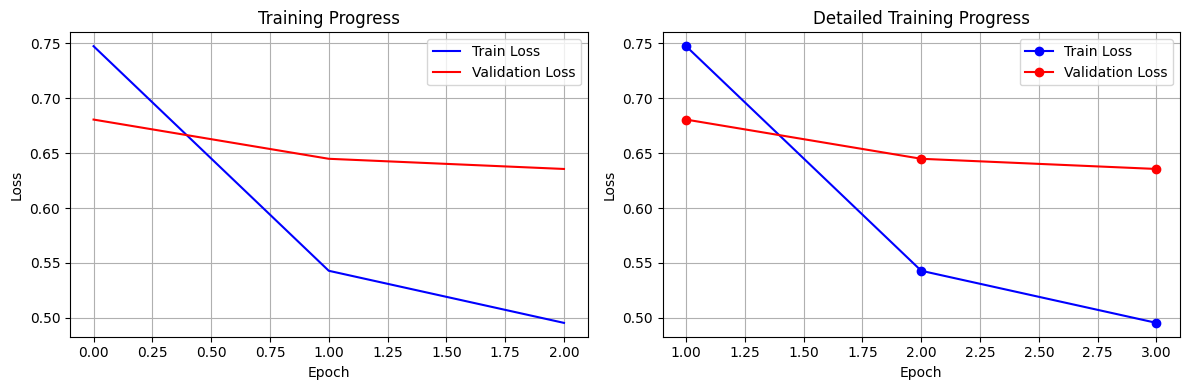

In [12]:
# ============================================================================
# CELL 11: Plot Training Progress
# ============================================================================

def plot_training_progress(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Detailed Training Progress')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training progress
plot_training_progress(train_losses, val_losses)


In [13]:
# ============================================================================
# CELL 12: Load Best Model for Inference
# ============================================================================

# Load the best model
checkpoint = torch.load('best_pipe_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Best model loaded (epoch {checkpoint['epoch'] + 1})")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}")


Best model loaded (epoch 3)
Best validation loss: 0.6356


In [42]:
# ============================================================================
# CELL 13: Inference Functions
# ============================================================================

def predict_pipes(model, image_path, confidence_threshold=0.5):
    """Predict pipes in a single image"""
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image)
    
    # Transform
    transform = get_transform(train=False)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Process predictions
    pred = predictions[0]
    
    # Filter by confidence
    keep = pred['scores'] > confidence_threshold
    boxes = pred['boxes'][keep].cpu().numpy()
    scores = pred['scores'][keep].cpu().numpy()
    
    return {
        'boxes': boxes,
        'scores': scores,
        'count': len(boxes),
        'original_image': image
    }

def visualize_predictions(image_path, predictions, save_path=None):
    """Visualize predictions on image (no big red total count)"""
    image = predictions['original_image'].copy()
    boxes = predictions['boxes']
    scores = predictions['scores']
    count = predictions['count']
    
    # Draw bounding boxes
    for i, (box, score) in enumerate(zip(boxes, scores)):
        x1, y1, x2, y2 = box.astype(int)
        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Draw confidence score
        cv2.putText(image, f'{score:.2f}', (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(f'Pipe Detection Results')
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


In [45]:
# ============================================================================
# CELL 14: Test on Sample Images
# ============================================================================

# Test on a few sample images
def test_sample_images():
    """Test the model on sample images"""
    
    # Get some test images
    test_images = []
    for root, dirs, files in os.walk(TEST_PATH):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_images.append(os.path.join(root, file))
                if len(test_images) >= 4:  # Test on 4 images
                    break
        if len(test_images) >= 4:
            break
    
    confidence_thresholds = [0.3, 0.5, 0.7]
    
    for img_path in test_images[:2]:  # Test on first 2 images
        print(f"\nTesting: {os.path.basename(img_path)}")
        
        for conf_thresh in confidence_thresholds:
            print(f"Confidence threshold: {conf_thresh}")
            
            # Predict
            predictions = predict_pipes(model, img_path, confidence_threshold=conf_thresh)
            print(f"Detected pipes: {predictions['count']}")
            
            # Visualize
            visualize_predictions(img_path, predictions)


In [43]:
# ============================================================================
# CELL 15: Evaluation on Test Set
# ============================================================================

def evaluate_counting_accuracy(model, test_loader, confidence_threshold=0.5):
    """Evaluate counting accuracy on test set"""
    model.eval()
    
    predicted_counts = []
    actual_counts = []
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            # Move to device
            images = [img.to(device) for img in images]
            
            # Get predictions
            predictions = model(images)
            
            # Process each image in batch
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                # Filter by confidence
                keep = pred['scores'] > confidence_threshold
                pred_count = keep.sum().item()
                actual_count = len(target['boxes'])
                
                predicted_counts.append(pred_count)
                actual_counts.append(actual_count)
    
    # Calculate metrics
    predicted_counts = np.array(predicted_counts)
    actual_counts = np.array(actual_counts)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(predicted_counts - actual_counts))
    
    # Mean Squared Error
    mse = np.mean((predicted_counts - actual_counts) ** 2)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # Accuracy (exact matches)
    accuracy = np.mean(predicted_counts == actual_counts)
    
    print(f"Evaluation Results (Confidence: {confidence_threshold}):")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Exact Count Accuracy: {accuracy:.2%}")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'accuracy': accuracy,
        'predicted': predicted_counts,
        'actual': actual_counts
    }

# Evaluate on test set if available
if test_ann_file:
    results = evaluate_counting_accuracy(model, test_loader, confidence_threshold=0.5)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(results['actual'], results['predicted'], alpha=0.6)
    plt.plot([0, max(results['actual'])], [0, max(results['actual'])], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Count')
    plt.ylabel('Predicted Count')
    plt.title('Actual vs Predicted Counts')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    errors = results['predicted'] - results['actual']
    plt.hist(errors, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


Evaluating:   0%|          | 0/15 [00:06<?, ?it/s]



KeyboardInterrupt: 

In [37]:
# ============================================================================
# CELL 16: Save Final Model and Results
# ============================================================================

# Save the final trained model
final_model_path = 'final_pipe_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': 2,
    'training_config': {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'epochs': len(train_losses),
        'best_val_loss': best_val_loss
    }
}, final_model_path)

print(f"Final model saved to: {final_model_path}")

# Save training history
import pickle
history_path = 'training_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }, f)

print(f"Training history saved to: {history_path}")

Final model saved to: final_pipe_model.pth
Training history saved to: training_history.pkl


In [46]:
# ============================================================================
# CELL 17: Create Inference Function for New Images
# ============================================================================

def load_model_for_inference(model_path):
    """Load trained model for inference"""
    model = create_model(num_classes=2)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

def count_pipes_in_image(model, image_path, confidence_threshold=0.5):
    """Count pipes in a single image and show visualisation"""
    predictions = predict_pipes(model, image_path, confidence_threshold)
    visualize_predictions(image_path, predictions)
    return predictions['count'], predictions

# Example usage for inference
print("\nInference Example:")
print("=" * 30)
print("# To use the trained model for inference:")
print("model = load_model_for_inference('/content/drive/MyDrive/pipe_counter_final.pth')")
print("count, predictions = count_pipes_in_image(model, 'path_to_image.jpg')")
print("print(f'Number of pipes detected: {count}')")

print("\nTraining completed successfully!")
print("Model is ready for pipe counting!")


Inference Example:
# To use the trained model for inference:
model = load_model_for_inference('/content/drive/MyDrive/pipe_counter_final.pth')
count, predictions = count_pipes_in_image(model, 'path_to_image.jpg')
print(f'Number of pipes detected: {count}')

Training completed successfully!
Model is ready for pipe counting!


In [47]:
model1 = load_model_for_inference('final_pipe_model.pth')

In [ ]:
count = count_pipes_in_image(model1, 'water_pipes_cover1.jpg')